## Create Initial states

In [1]:
import numpy as np
from pathlib import Path
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt

from src.models.mixture import MixtureDegModel
from src.models.normal import NormalDegradationModel as NModel
from src.models.particle_filter import ParticleFilterModel,ParticleFilterMLP

In [2]:
data_name = "DS03"

device = "cpu"
experiment_dir = Path('experiments')/data_name
states_dir = experiment_dir/'states'
os.makedirs(states_dir, exist_ok=True)

## Import training data


In [3]:
hi_df = pd.read_csv(experiment_dir/'hidata_dev.csv')

### get only degraded data

In [4]:
hi_df = hi_df[hi_df['hs']==0]
del hi_df['hs']

In [5]:
perform_alias = [col for col in hi_df.columns if col not in ['unit','cycle']]
units = hi_df['unit'].unique().tolist()

In [6]:
performs_train = {alias: 
    {int(unit): hi_df[hi_df['unit']==unit][alias].values for unit in units} 
    for alias in perform_alias
}
time_train = {int(unit): hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

## Load best model

In [7]:
t = np.linspace(0.1, 100, 400)  # Start from 0.1 instead of 0.0 (LogNormal support is t > 0)
s = np.linspace(0.0, 1.0, 300)
trian_units = range(1,9)

pf_models: dict[str,ParticleFilterModel]= {}
comp_models = {}
for name, units_perform in performs_train.items():
    models = []
    for unit, perform in units_perform.items():
        if unit not in trian_units:
            continue
        best_model = NModel()
        best_model.load_state_dict(
			torch.load(states_dir /name/f'unit_{unit}'/ "best_model.pt", map_location=device)
		)
        best_model.to(device)
        best_model.eval()
        models.append(best_model)
    
    pf_models[name]=ParticleFilterModel(base_models=models,
                        max_life = 100.0,
                        multiply_scale=0.01,
                        n_particles=800,
                        name = name).to(device)
    comp_models[name]= models
    
    
    

## Mixture pdf 

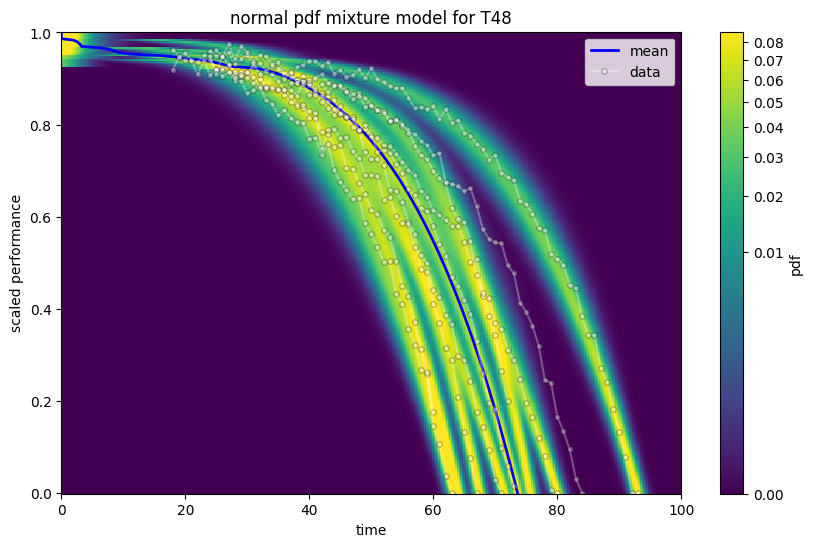

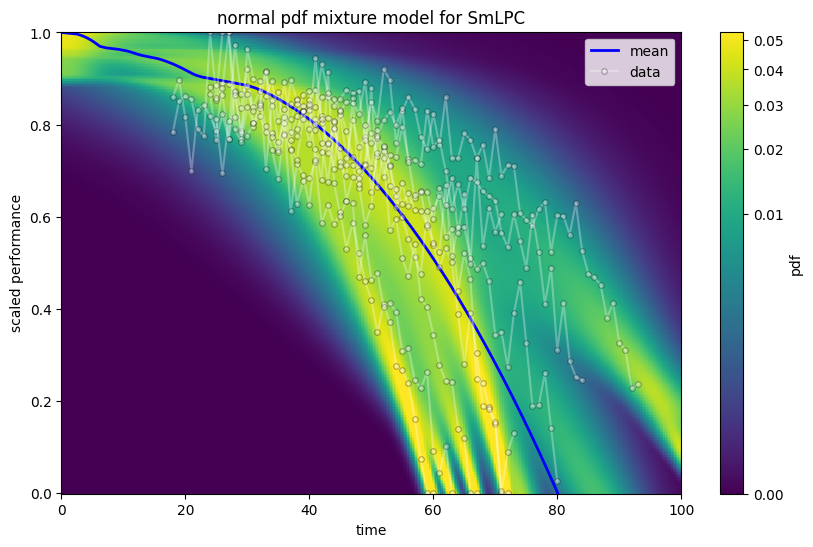

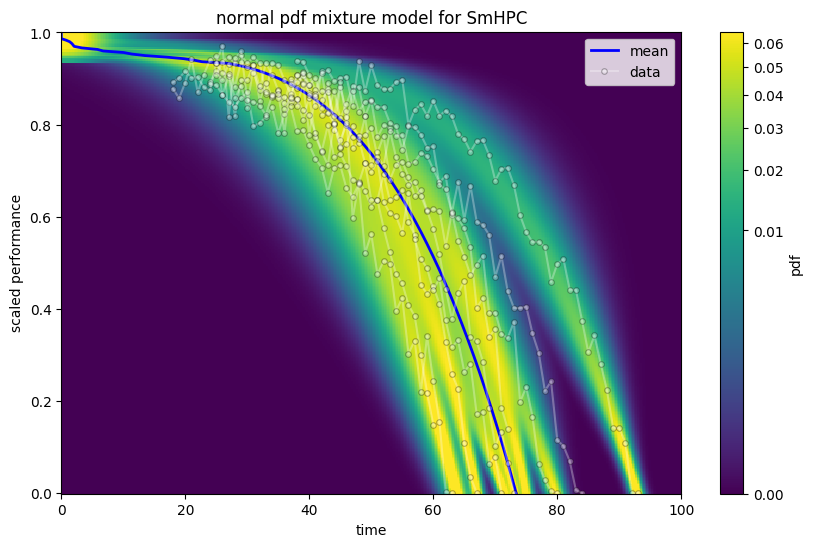

In [8]:
for name, pf_model in pf_models.items():
    ## Plot mix model
    mix_model = pf_model.mixture
    ax=mix_model.plot_distribution(t, s, 
                    func="pdf",
					title=f"normal pdf mixture model for {name}",
					plot_mean=True,
		)
    
    # Plot data
    first = True
    for unit,s_data in performs_train[name].items():
        t_data = time_train[unit]
        ax.plot(t_data,s_data,'o-',
				color='white',alpha=0.3,markersize=4,markeredgecolor='black',markeredgewidth=0.8,
				label='data' if first else None)
        first = False
    
    # adjust and plot
    ax.set_xlim([0, t.max()])
    ax.legend()
    plt.show()

## Select PF and unit for online test

In [9]:
perform_name = "T48"  # pick first degradation signal
pf = pf_models[perform_name]
base_models = comp_models[perform_name]
unit_id = list(performs_train[perform_name].keys())[-1]
t_data = time_train[unit_id]
s_data = performs_train[perform_name][unit_id]

print(f"Testing PF '{perform_name}' on unit {unit_id}")

Testing PF 'T48' on unit 9


In [10]:
def make_pf(shared_net: ParticleFilterMLP) -> ParticleFilterModel:
    pf = ParticleFilterModel(
        base_models=base_models,
        max_life=100.0,
        n_particles=800,
        multiply_scale=0.01,
        name="T48",
    )
    pf.net = shared_net  # 🔑 inject trained NN
    return pf

## Frame renderer


In [11]:
def render_pf_frame(
    pf: ParticleFilterModel,
    t_grid: np.ndarray,
    s_grid: np.ndarray,
    t_obs: np.ndarray,
    s_obs: np.ndarray,
    title: str,
):
    fig, ax = plt.subplots(figsize=(9, 5))

    # Mixture PDF
    pf.mixture.plot_distribution(
        t_grid,
        s_grid,
        func="pdf",
        ax=ax,
        plot_mean=True,
        title=title,
    )

    # Observed data
    ax.plot(
        t_obs,
        s_obs,
        "o-",
        color="white",
        alpha=0.8,
        markersize=4,
        markeredgecolor="black",
        markeredgewidth=0.8,
        label="observations",
    )

    ax.set_xlim([0, t_grid.max()])
    ax.set_ylim([0, 1.05])
    ax.legend()

    fig.canvas.draw()
    img = np.asarray(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)
    return img

In [12]:
def make_pf(shared_net: ParticleFilterMLP) -> ParticleFilterModel:
    pf = ParticleFilterModel(
        base_models=base_models,
        max_life=100.0,
        n_particles=800,
        multiply_scale=0.01,
        name="T48",
    )
    pf.net = shared_net  # 🔑 inject trained NN
    return pf

In [13]:
def collect_grad_stats(net):
    stats = {}
    for name, p in net.named_parameters():
        if p.grad is None:
            continue
        stats[name] = {
            "norm": p.grad.norm().item(),
            "mean": p.grad.mean().item(),
            "std": p.grad.std().item(),
            "max": p.grad.abs().max().item(),
        }
    return stats

## Run PF online and collect frames


In [14]:
# grids for visualization
t_grid = np.linspace(0.1, 100, 400)
s_grid = np.linspace(0.0, 1.0, 300)


# # ground-truth EOL
eol = torch.tensor(t_data[-1], dtype=torch.float32)

# # PF hyperparameters for test
# noise_scale = 0.05
start_idx = 1     # PF needs a few observations
step_stride = 1    # skip frames to keep video short


shared_net = ParticleFilterMLP(layer_dims=[2, 32, 32, 16, 2])
# optimizer = torch.optim.Adam(shared_net.parameters(), lr=1e-3)
# n_epochs = 200
# grad_history = []

# for epoch in range(n_epochs):
#     optimizer.zero_grad()
#     total_loss = 0.0

#     pf = make_pf(shared_net)

#     for k in range(start_idx, len(t_data)):
#         t_obs = torch.tensor(t_data[:k], dtype=torch.float32)
#         s_obs = torch.tensor(s_data[:k], dtype=torch.float32)

#         loss = pf.step(t_obs=t_obs, s_obs=s_obs, eol=eol)
#         total_loss = total_loss + loss

#     total_loss.backward()

#     grad_stats = collect_grad_stats(shared_net)
#     grad_history.append((epoch, grad_stats, total_loss.item()))

#     optimizer.step()

#     print(
#         f"[Epoch {epoch:03d}] "
#         f"loss={total_loss.item():.2f} | "
#         f"grad_norm={sum(v['norm'] for v in grad_stats.values()):.4e}"
#     )

In [15]:
import imageio
from pathlib import Path
t_grid = np.linspace(0.1, 100, 400)
s_grid = np.linspace(0.0, 1.0, 300)


# # ground-truth EOL
eol = torch.tensor(t_data[-1], dtype=torch.float32)
video_dir = Path("pf_epoch_videos")
video_dir.mkdir(exist_ok=True)
start_idx = 1     # PF needs a few observations
step_stride = 1    # skip frames to keep video short


shared_net = ParticleFilterMLP(layer_dims=[2, 32, 32, 16, 2])
n_epochs = 5000
optimizer = torch.optim.Adam(shared_net.parameters(), lr=1e-3)

for epoch in range(n_epochs):
    #print(f"\n===== Epoch {epoch:03d} =====")

    # ----------------------------------------
    # Reset PF but reuse the SAME NN
    # ----------------------------------------
    pf = make_pf(shared_net)
    optimizer.zero_grad()

    frames = []
    total_loss = 0.0

    for k in range(start_idx, len(t_data), step_stride):#
        t_obs = torch.tensor(t_data[:k], dtype=torch.float32)
        s_obs = torch.tensor(s_data[:k], dtype=torch.float32)

        # --- PF step (returns loss) ---
        loss = pf.step(
            t_obs=t_obs,
            s_obs=s_obs,
            eol=eol,
        )
        total_loss = total_loss + loss

    # ----------------------------------------
    # Backprop ONCE per epoch
    # ----------------------------------------
    total_loss.backward()
    optimizer.step()

    print(f"[Epoch {epoch:03d}] total_loss = {total_loss.item():.2f}")


[Epoch 000] total_loss = 171.86
[Epoch 001] total_loss = 171.32
[Epoch 002] total_loss = 172.91
[Epoch 003] total_loss = 173.91
[Epoch 004] total_loss = 169.68
[Epoch 005] total_loss = 174.05
[Epoch 006] total_loss = 177.32
[Epoch 007] total_loss = 175.02
[Epoch 008] total_loss = 174.66
[Epoch 009] total_loss = 178.70
[Epoch 010] total_loss = 171.47
[Epoch 011] total_loss = 174.67
[Epoch 012] total_loss = 164.12
[Epoch 013] total_loss = 169.60
[Epoch 014] total_loss = 171.96
[Epoch 015] total_loss = 177.88
[Epoch 016] total_loss = 176.04
[Epoch 017] total_loss = 174.96
[Epoch 018] total_loss = 173.53
[Epoch 019] total_loss = 167.33
[Epoch 020] total_loss = 170.61
[Epoch 021] total_loss = 174.36
[Epoch 022] total_loss = 172.55
[Epoch 023] total_loss = 171.01
[Epoch 024] total_loss = 169.54
[Epoch 025] total_loss = 170.54
[Epoch 026] total_loss = 172.13
[Epoch 027] total_loss = 173.44
[Epoch 028] total_loss = 168.29
[Epoch 029] total_loss = 168.18
[Epoch 030] total_loss = 173.07
[Epoch 0

## Save video

In [16]:
video_path = f"pf_{perform_name}_unit{unit_id}.mp4"

with imageio.get_writer(video_path, fps=8, macro_block_size=1) as writer:
    for frame in frames:
        writer.append_data(frame)

print(f"🎬 Video saved to {video_path}")

🎬 Video saved to pf_T48_unit9.mp4


In [20]:
x = torch.cat([t_obs.unsqueeze(-1), s_obs.unsqueeze(-1)], dim=-1)
pf.net(x)

tensor([[  0.4542,   0.5523],
        [  0.4545,   0.5711],
        [  0.4527,   0.5837],
        [  0.4540,   0.6070],
        [  0.4566,   0.6351],
        [  0.4555,   0.6513],
        [  0.4579,   0.6804],
        [  0.4564,   0.6956],
        [  0.4564,   0.7171],
        [  0.4584,   0.7465],
        [  0.4607,   0.7777],
        [  0.4601,   0.7982],
        [  0.4609,   0.8249],
        [  0.4630,   0.8575],
        [  0.4647,   0.8890],
        [  0.4656,   0.9180],
        [  0.4681,   0.9545],
        [  0.4680,   0.9802],
        [  0.4692,   1.0122],
        [  0.4720,   1.0518],
        [  0.4725,   1.0821],
        [  0.4747,   1.1205],
        [  0.4761,   1.1560],
        [  0.4792,   1.2002],
        [  0.4787,   1.2271],
        [  0.4871,   1.2999],
        [  0.4880,   1.3350],
        [  0.4889,   1.3708],
        [  0.4905,   1.4110],
        [  0.4899,   1.4393],
        [  0.4953,   1.5010],
        [  0.5022,   1.5711],
        [  0.5053,   1.6215],
        [ 

In [21]:
frames = []
total_loss = 0.0

for k in range(start_idx, len(t_data), step_stride):#
	t_obs = torch.tensor(t_data[:k], dtype=torch.float32)
	s_obs = torch.tensor(s_data[:k], dtype=torch.float32)

	# --- PF step (returns loss) ---
	loss = pf.step(
		t_obs=t_obs,
		s_obs=s_obs,
		eol=eol,
	)
	total_loss = total_loss + loss

	# --- render frame ---
	fig, ax = plt.subplots(figsize=(10, 8))
	pf.plot(
	    ax=ax,
	    t_grid=t_grid,
	    s_grid=s_grid,
	    t_obs=t_data[:k],
	    s_obs=s_data[:k],
	    title=f"Epoch {epoch} | step {k}",
	)

	fig.canvas.draw()
	frame = np.asarray(fig.canvas.renderer.buffer_rgba())
	plt.close(fig)
	frames.append(frame)

/var/folders/hl/2v5kr9994fl_j6sv_4mt0bn00000gn/T/ipykernel_9401/2333881085.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.draw()


## Save video

In [22]:
video_path = f"pf_{perform_name}_unit{unit_id}.mp4"

with imageio.get_writer(video_path, fps=8, macro_block_size=1) as writer:
    for frame in frames:
        writer.append_data(frame)

print(f"🎬 Video saved to {video_path}")

🎬 Video saved to pf_T48_unit9.mp4
